In [1]:
#Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15,10)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Loading Dataset

In [2]:
df1 = pd.read_csv("Data.csv")
df1.head()

,Unnamed: 0,Property_Name,Property Title,Price,Location,Total_Area(SQFT),Price_per_SQFT,Description,Total_Rooms,Balcony,city,property_type,BHK
0,0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",19900000,"Kanathur Reddikuppam, Chennai",2583,7700,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes,Chennai,Flat,4.0
1,1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,22500000,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210,Looking for a 10 BHK Independent House for sal...,6,Yes,Chennai,House,10.0
2,2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",10000000,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580,"Property for sale in Tambaram, Chennai. This 3...",3,No,Chennai,Flat,3.0
3,3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,33300000,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840,Entire Building for sale with 7 units of singl...,5,Yes,Chennai,House,7.0
4,4,DRA 90 Degrees,"3 BHK Flat for sale in Pallikaranai, Chennai",13000000,"Rose Avenue, Pallikaranai,Chennai",1444,9000,Looking for a 3 BHK Apartment for sale in Chen...,3,No,Chennai,Flat,3.0


Dropping Unnecessary Columns and Renaming the Columns

In [3]:
df2 = df1.drop(['Unnamed: 0','Property_Name','Property Title','Description','BHK','Balcony','city'], axis = 'columns')
df2 = df2.rename(columns = {'Total_Area(SQFT)' : 'Area', 'Total_Rooms' : 'BHK', 'Price_per_SQFT': 'Rate', 'property_type' : 'Type' })
df2.head()

,Price,Location,Area,Rate,BHK,Type
0,19900000,"Kanathur Reddikuppam, Chennai",2583,7700,4,Flat
1,22500000,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210,6,House
2,10000000,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580,3,Flat
3,33300000,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840,5,House
4,13000000,"Rose Avenue, Pallikaranai,Chennai",1444,9000,3,Flat


Handling Null values

In [4]:
df2.isnull().sum()

Price       0
Location    0
Area        0
Rate        0
BHK         0
Type        0
dtype: int64

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     14525 non-null  int64 
 1   Location  14525 non-null  object
 2   Area      14525 non-null  int64 
 3   Rate      14525 non-null  int64 
 4   BHK       14525 non-null  int64 
 5   Type      14525 non-null  object
dtypes: int64(4), object(2)
memory usage: 681.0+ KB


Feature Engineering (Manipulating features to make them Model Training Ready)

In [6]:
df2.Price = df2.Price.apply(lambda x: x/100000)       #Scaling down price to improve readability
df2.head()

,Price,Location,Area,Rate,BHK,Type
0,199.0,"Kanathur Reddikuppam, Chennai",2583,7700,4,Flat
1,225.0,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210,6,House
2,100.0,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580,3,Flat
3,333.0,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840,5,House
4,130.0,"Rose Avenue, Pallikaranai,Chennai",1444,9000,3,Flat


Label Encoding Categorial Data

In [7]:
df2.Type.unique()

array(['Flat', 'House', 'Villa'], dtype=object)

In [8]:
#Label Encoding
def label_encode(x):
    if str(x) == 'House':
        return 1
    elif str(x) == 'Flat':
        return 2
    else:
        return 3

In [9]:
df2.Type = df2.Type.apply(label_encode)
df2.head()

,Price,Location,Area,Rate,BHK,Type
0,199.0,"Kanathur Reddikuppam, Chennai",2583,7700,4,2
1,225.0,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210,6,1
2,100.0,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580,3,2
3,333.0,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840,5,1
4,130.0,"Rose Avenue, Pallikaranai,Chennai",1444,9000,3,2


In [10]:
#Removing Data Redundancy
df3 = df2.copy()
df3.Location = df3.Location.apply(lambda x: (x.split(',')[-2]).strip() + ',' + (x.split(',')[-1]).strip())
df3.head()

,Price,Location,Area,Rate,BHK,Type
0,199.0,"Kanathur Reddikuppam,Chennai",2583,7700,4,2
1,225.0,"Pozhichalur,Chennai",7000,3210,6,1
2,100.0,"West Tambaram,Chennai",1320,7580,3,2
3,333.0,"Triplicane,Chennai",4250,7840,5,1
4,130.0,"Pallikaranai,Chennai",1444,9000,3,2


In [11]:
len(df3.Location.unique())

1800

In [12]:
loc_stat = df3.groupby('Location')['Location'].agg('count').sort_values(ascending = False)
loc_stat

Location
Electronic City,Bangalore    103
Hadapsar,Pune                 96
Mira Road East,Mumbai         90
Chandapura,Bangalore          69
Talegaon Dabhade,Pune         69
                            ... 
Irandankattalai,Chennai        1
Sarada Pally,Kolkata           1
Irumbuliyur,Chennai            1
Santosh Nagar,Hyderabad        1
,Kolkata                       1
Name: Location, Length: 1800, dtype: int64

In [13]:
len(loc_stat[loc_stat < 10])

1315

Dimensionality Reduction

In [14]:
low_stat = loc_stat[loc_stat < 10]
df3['Location'] = df3['Location'].apply(lambda x: 'Other' if x in low_stat else x)
df3.head(20)

,Price,Location,Area,Rate,BHK,Type
0,199.0,Other,2583,7700,4,2
1,225.0,Other,7000,3210,6,1
2,100.0,"West Tambaram,Chennai",1320,7580,3,2
3,333.0,"Triplicane,Chennai",4250,7840,5,1
4,130.0,"Pallikaranai,Chennai",1444,9000,3,2
5,850.0,Other,6000,14170,1,3
6,115.0,Other,878,13100,3,2
7,260.0,Other,1658,15680,3,2
8,297.0,"Muttukadu,Chennai",4200,7070,5,2
9,162.0,Other,2838,5710,4,1


In [15]:
len(df3.Location.unique())

486

In [16]:
len(df3[(df3.Location == 'Other')])

4530

Outlier Removal

In [17]:
df4 = df3.copy()
df4['Check'] = df4.apply(lambda row: row['Area'] * row['Rate'] / 10**5, axis = 1)
df4['Check'] = df4['Check'].round()
df4.head()

,Price,Location,Area,Rate,BHK,Type,Check
0,199.0,Other,2583,7700,4,2,199.0
1,225.0,Other,7000,3210,6,1,225.0
2,100.0,"West Tambaram,Chennai",1320,7580,3,2,100.0
3,333.0,"Triplicane,Chennai",4250,7840,5,1,333.0
4,130.0,"Pallikaranai,Chennai",1444,9000,3,2,130.0


In [18]:
df4[df4.Price != df4.Check]

,Price,Location,Area,Rate,BHK,Type,Check
413,327.00,"Kartik Nagar,Bangalore",2720,12000,4,1,326.0
438,900.00,"Vidyaranyapura,Bangalore",12321,7300,1,1,899.0
510,139.00,"RR Nagar,Bangalore",2400,5770,4,2,138.0
604,117.00,Other,1800,6470,3,3,116.0
678,230.00,Other,26000,884000,4,3,229840.0
...,...,...,...,...,...,...,...
14474,23.50,Other,650,3620,2,2,24.0
14484,33.50,Other,455,7360,2,1,33.0
14490,8.00,"Mahavir Enclave,New Delhi",900,888000,3,2,7992.0
14509,24.00,"Kirari Suleman Nagar,New Delhi",5000,480000,5,1,24000.0


In [19]:
df4 = df4[df4.Price == df4.Check]
df4.shape

(13449, 7)

In [20]:
df5 = df4.drop(['Check'], axis = 'columns')
df5.shape

(13449, 6)

In [21]:
df5.Rate.describe()

count    13449.000000
mean      8506.558108
std       7334.069311
min       1000.000000
25%       4540.000000
50%       6190.000000
75%       9540.000000
max      92590.000000
Name: Rate, dtype: float64

In [22]:
def remove_rate_outlier(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('Location'):
        m = np.mean(subdf.Rate)
        st = np.std(subdf.Rate)
        reduced_df = subdf[(subdf.Rate > (m-st)) & (subdf.Rate <= (m+st))]
        df_out = pd.concat([df_out, reduced_df],ignore_index = True)
    return df_out

In [ ]:
df6 = remove_rate_outlier(df5)
df6.shape

(10814, 6)

In [24]:
df6.Rate.describe()

count    10814.000000
mean      7268.850564
std       4612.399823
min       1000.000000
25%       4540.000000
50%       5910.000000
75%       8330.000000
max      51320.000000
Name: Rate, dtype: float64

Data Visualization

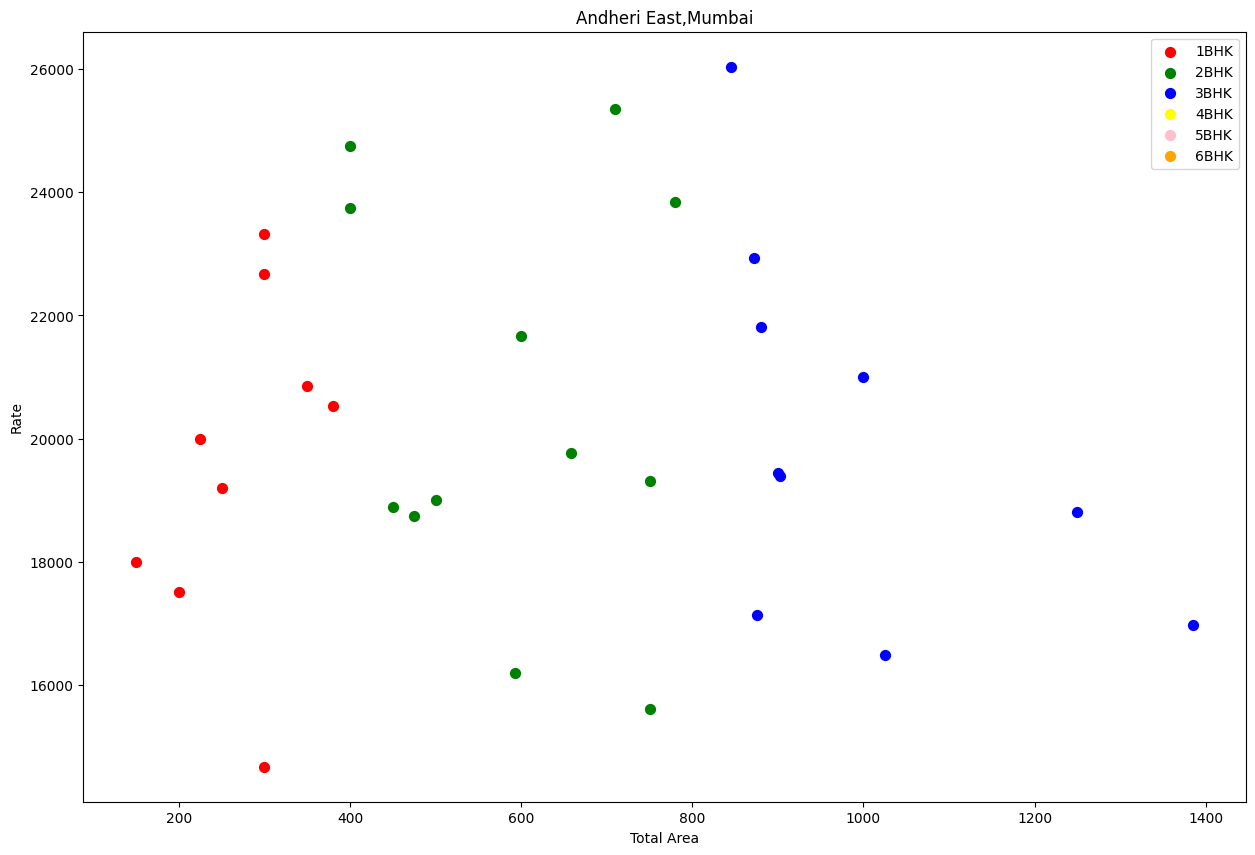

In [ ]:
def plot_scatter(df,location):
    legends = {1: 'red', 2:'green', 3:'blue', 4:'yellow', 5:'pink', 6:'orange'}
    for i in legends:
        bhkx = df[(df.Location == location) & (df.BHK == i)]
        plt.scatter(bhkx.Area, bhkx.Rate, color = legends[i], label = str(i)+'BHK', s=50)
    
    plt.xlabel('Total Area')
    plt.ylabel('Rate')
    plt.title(location)
    plt.legend()

plot_scatter(df6, 'Andheri East,Mumbai')

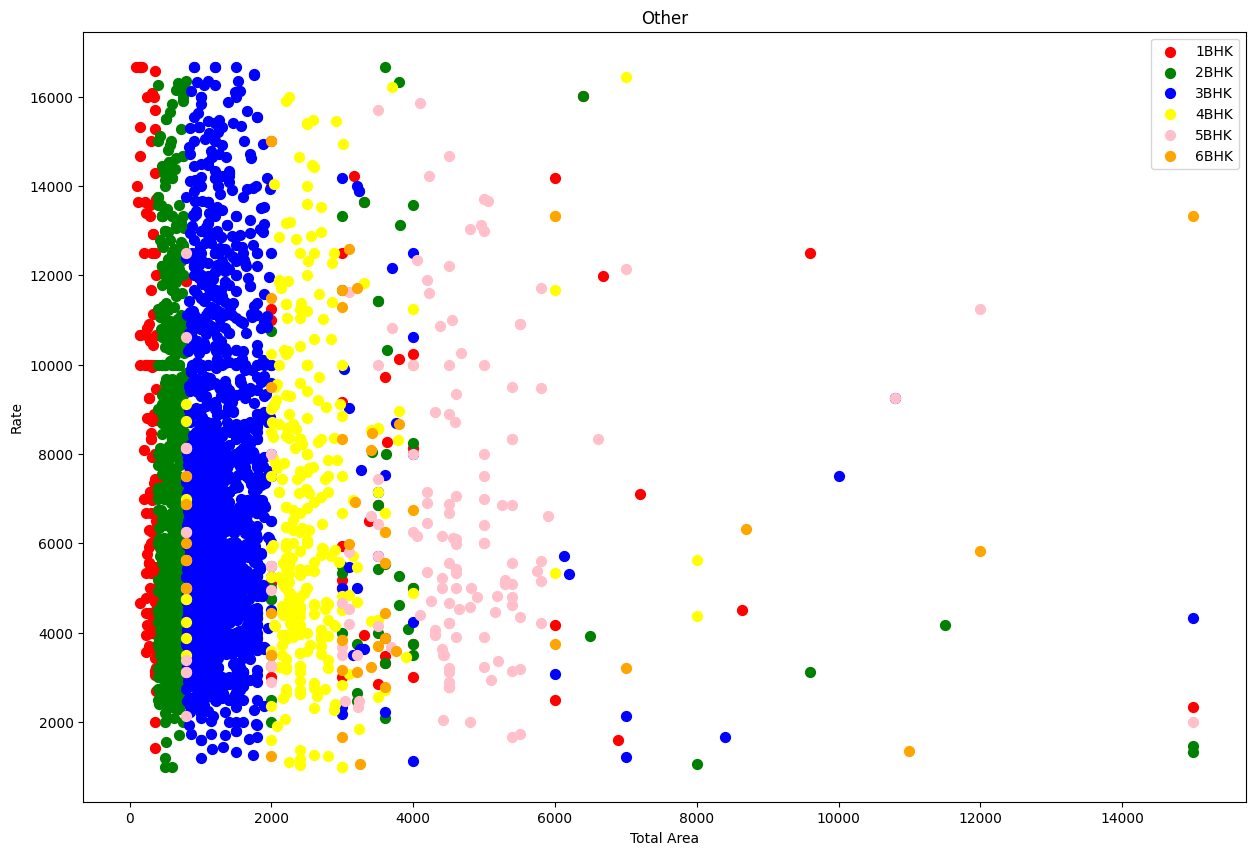

In [26]:
plot_scatter(df6, 'Other')

In [27]:
df6[df6.Location == 'Other'].shape

(3809, 6)

In [28]:
def remove_bhk_rate_outlier(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('Location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                'mean' : np.mean(bhk_df.Rate),
                'std' : np.std(bhk_df.Rate),
                'count' : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.Rate < (stats['mean'] - stats['std'])].index.values)
    return df.drop(exclude_indices, axis = 'index')

In [29]:
df7 = remove_bhk_rate_outlier(df6)
df7.shape

(10088, 6)

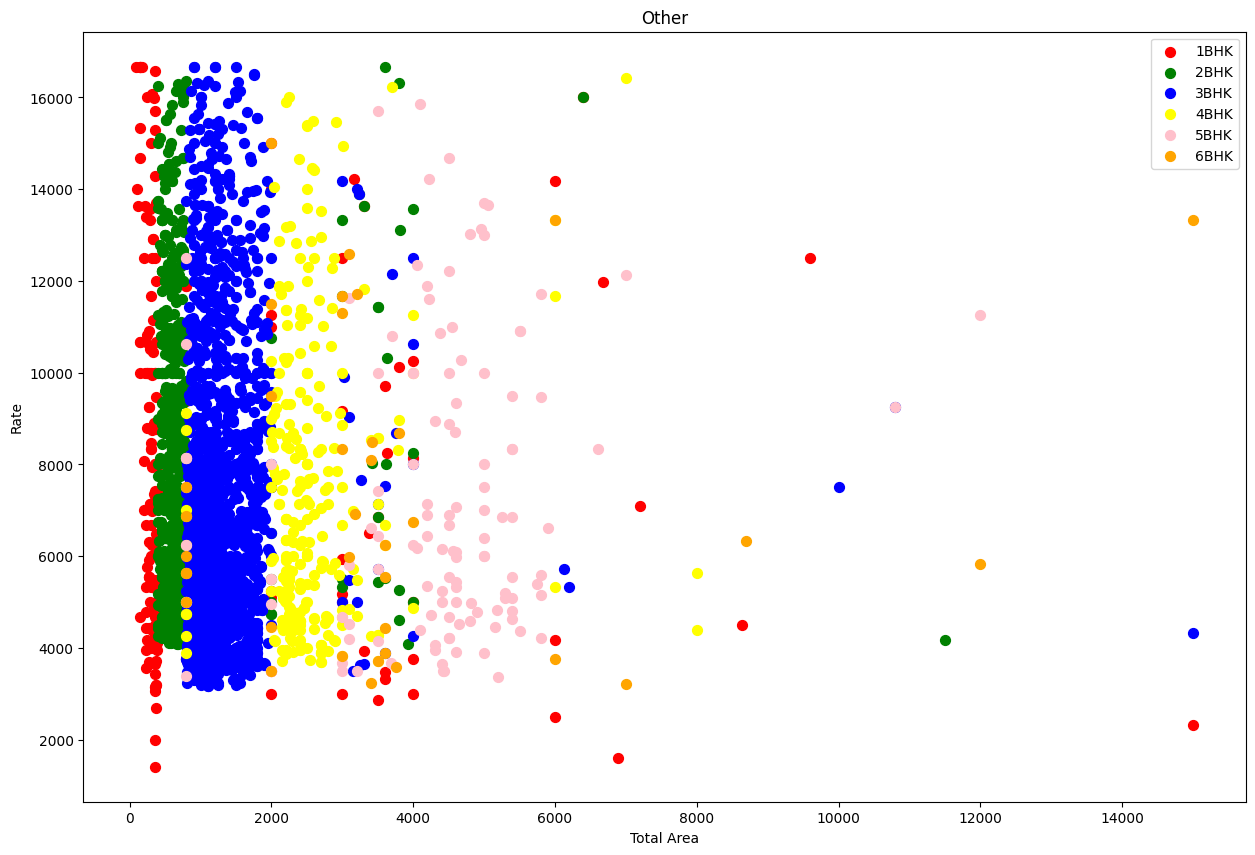

In [30]:
plot_scatter(df7, 'Other')

In [31]:
def plot_hist_rate(df):
    sns.histplot(df.Rate,bins=50,kde=1)
    plt.xlabel('Rate')
    plt.ylabel('Count')
def plot_hist_area(df):
    sns.histplot(df.Area,bins=50,kde=1)
    plt.xlabel('Area')
    plt.ylabel('Count')
def plot_hist_price(df):
    sns.histplot(df.Price,bins=50,kde=1)
    plt.xlabel('Price')
    plt.ylabel('Count')

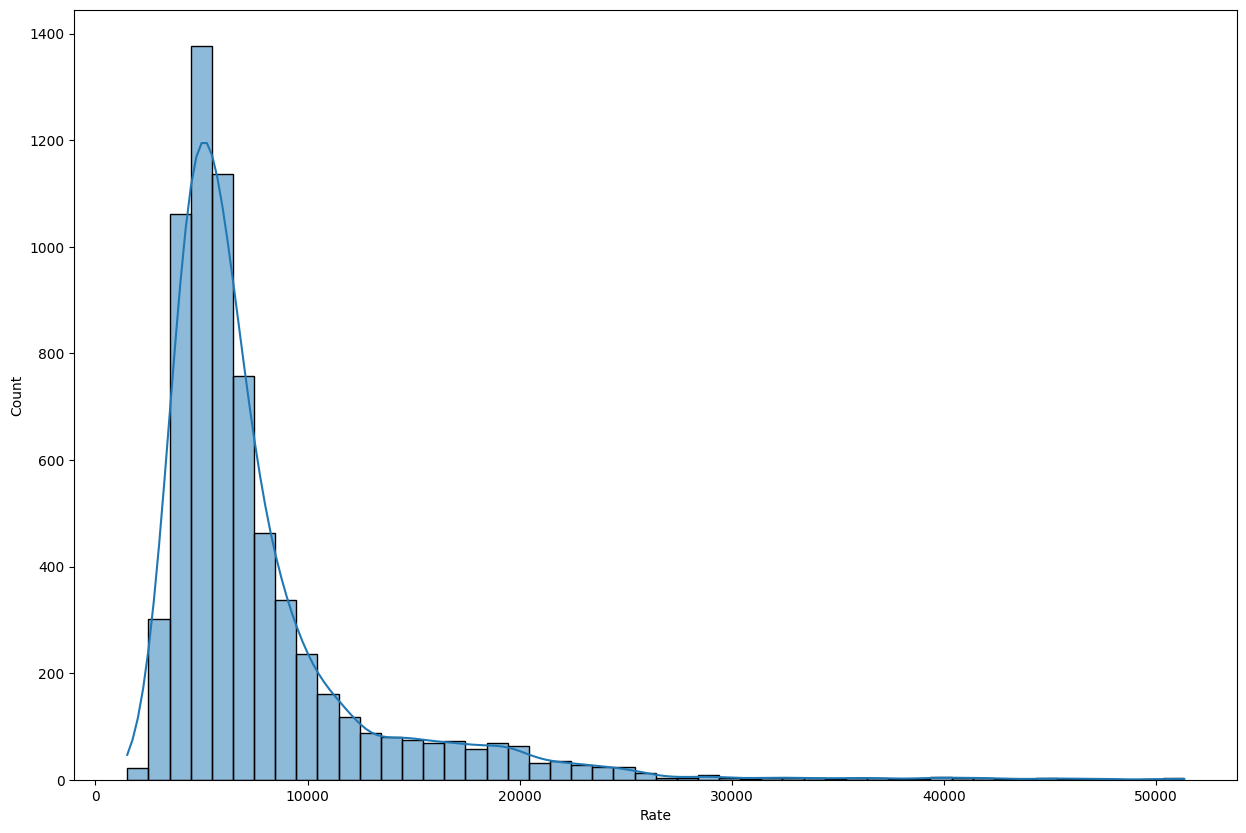

In [32]:
df8 = df7[df7.Location != 'Other']
plot_hist_rate(df8)

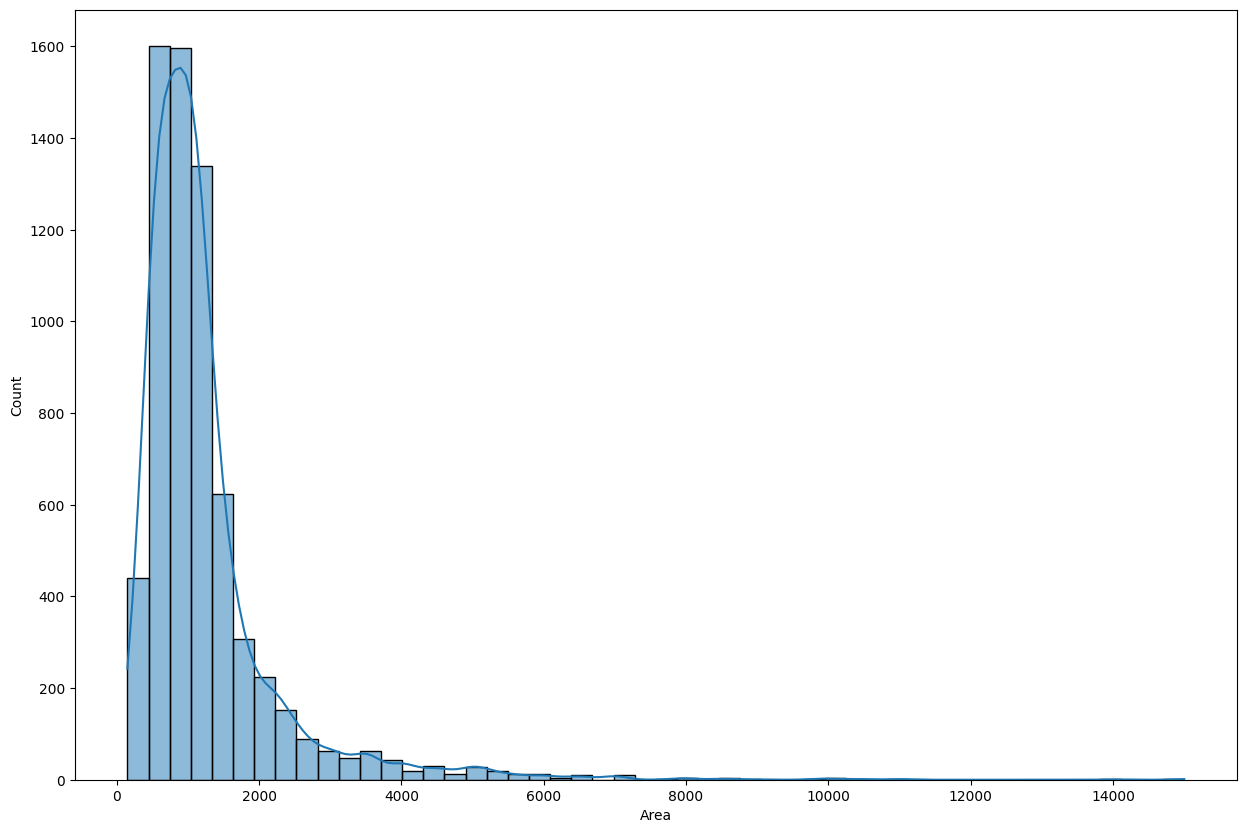

In [33]:
plot_hist_area(df8)

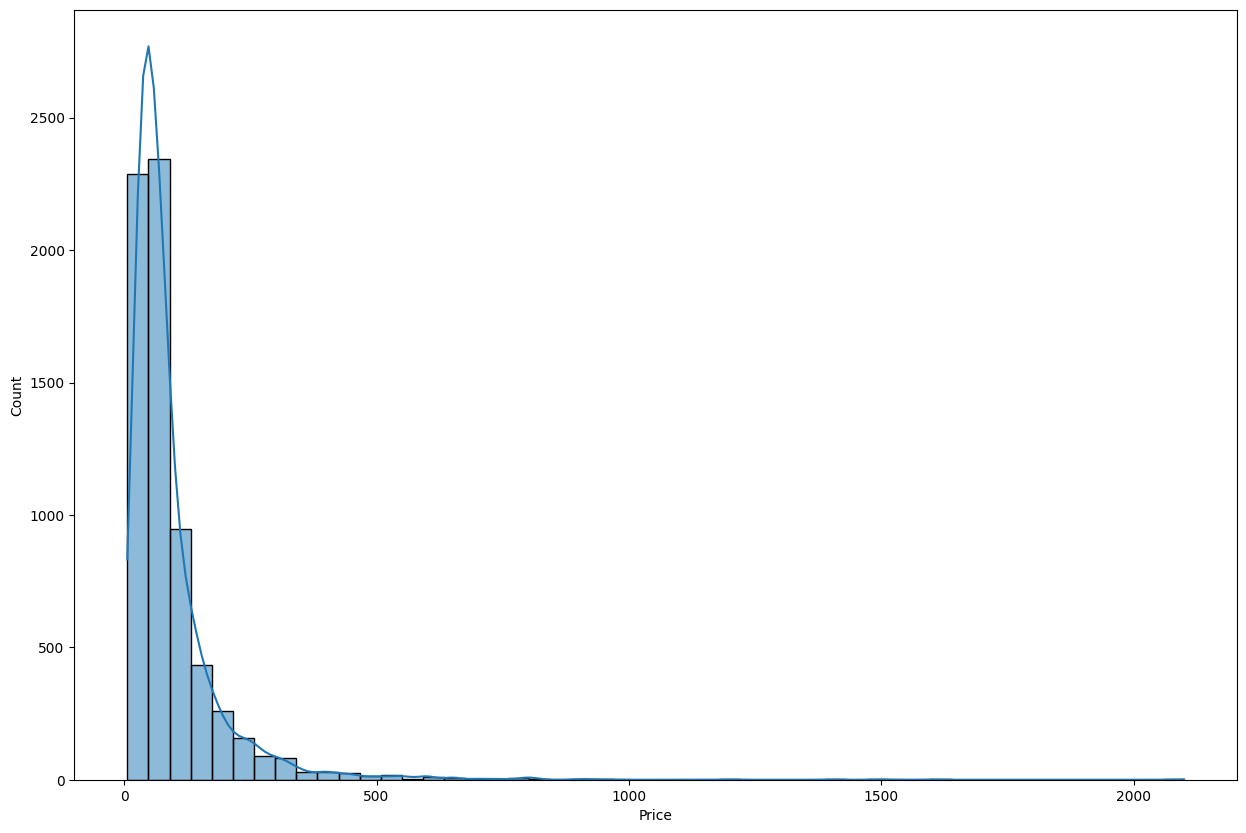

In [34]:
plot_hist_price(df8)

In [35]:
#Performing Log Transformation
logged_df = df8.copy()
logged_df.Rate = np.log(logged_df.Rate)
logged_df.Area = np.log(logged_df.Area)
logged_df.Price = np.log(logged_df.Price)

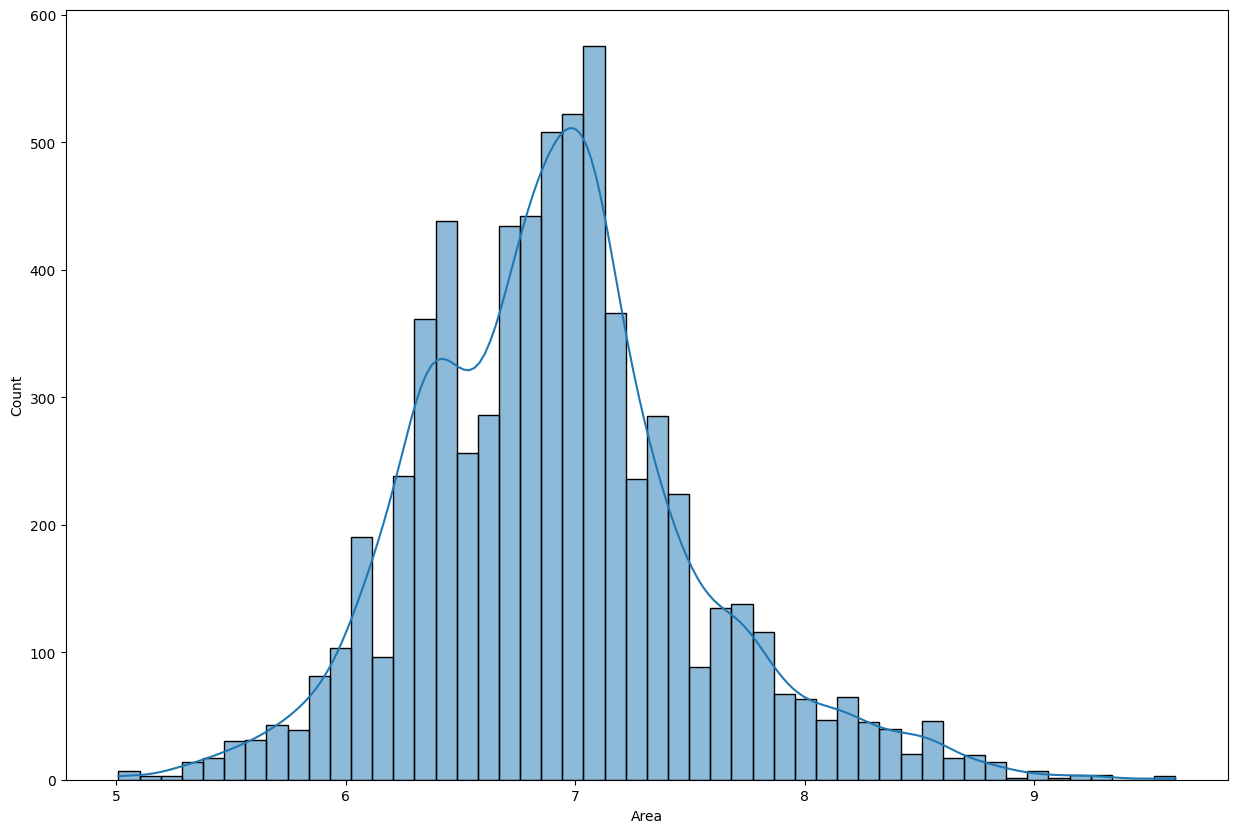

In [36]:
plot_hist_area(logged_df)

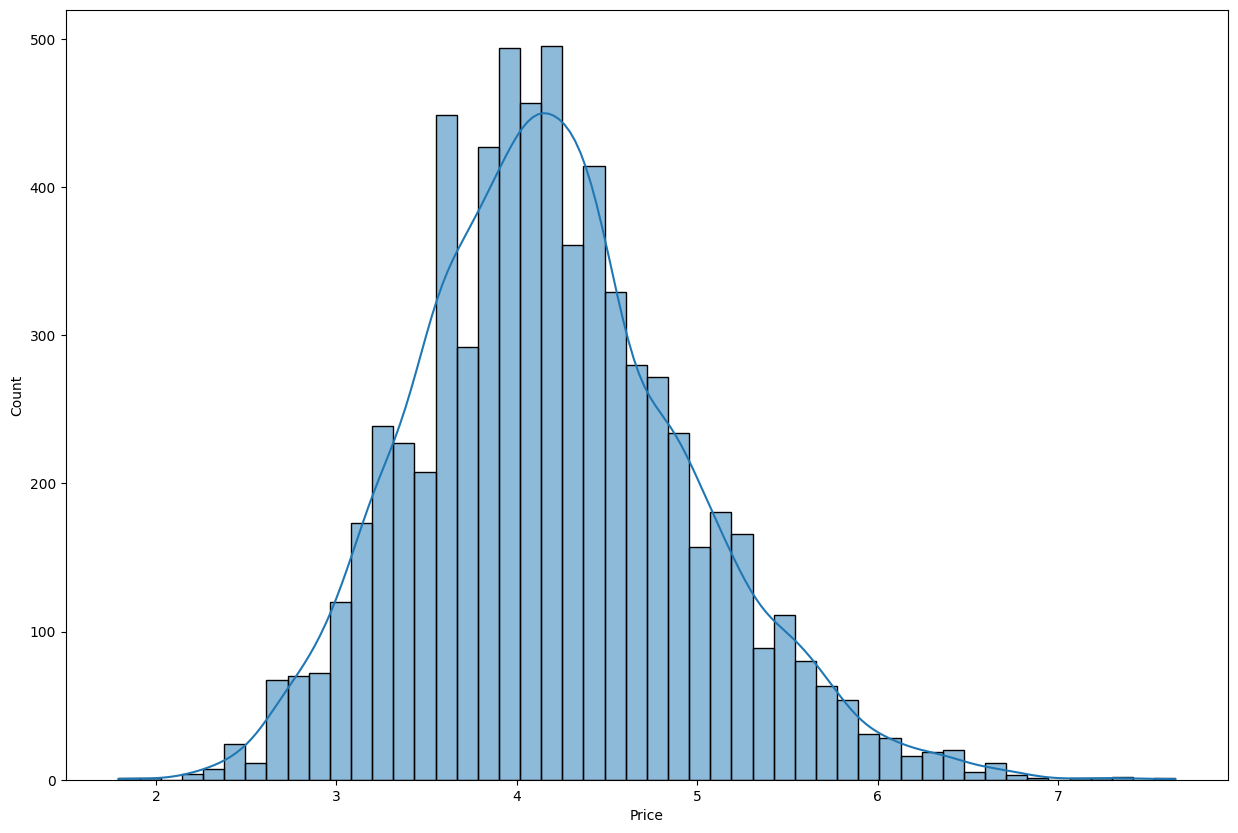

In [37]:
plot_hist_price(logged_df)

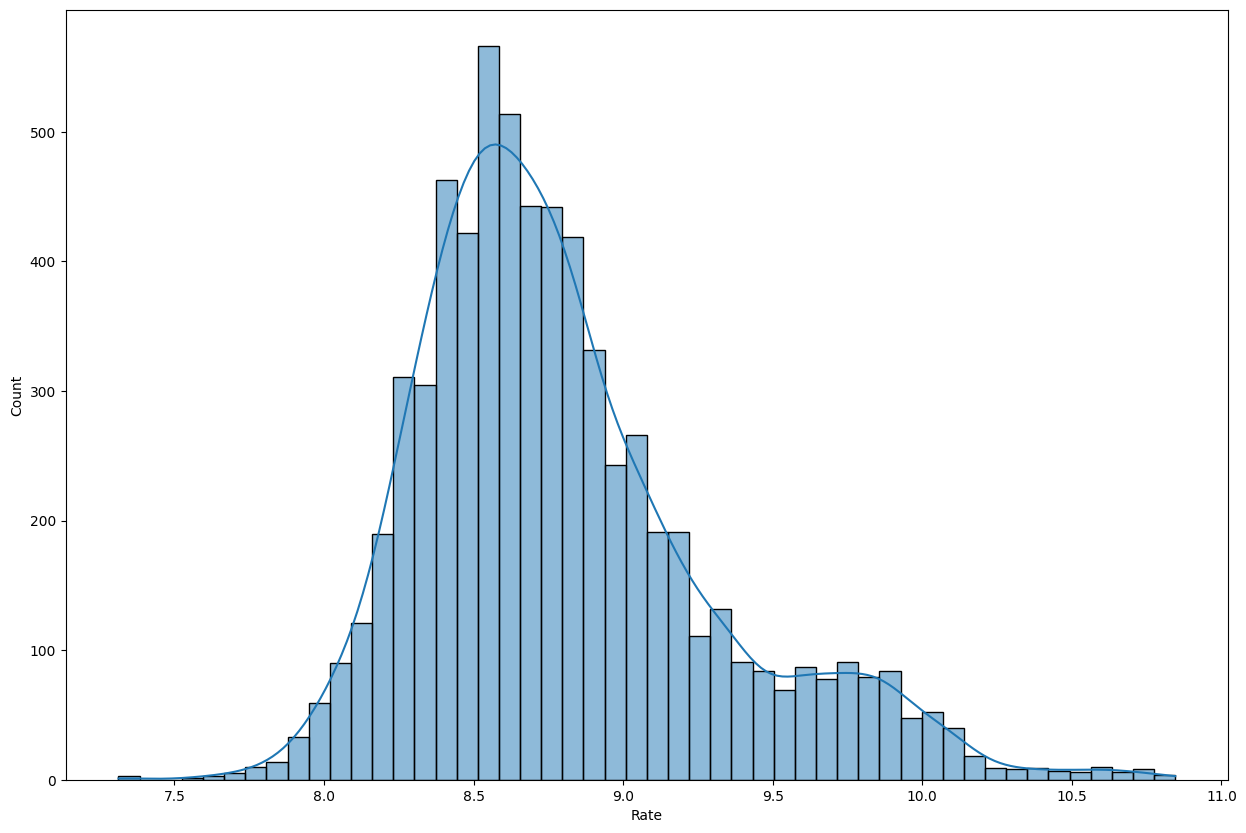

In [38]:
plot_hist_rate(logged_df)

In [39]:
df9 = logged_df.copy()
df9.copy()

,Price,Location,Area,Rate,BHK,Type
0,4.787492,"Abbigere,Bangalore",8.006368,8.294050,4,1
1,5.105945,"Abbigere,Bangalore",8.242756,8.375630,4,1
2,4.941642,"Abbigere,Bangalore",7.901007,8.552560,4,1
3,4.905275,"Abbigere,Bangalore",8.188689,8.229511,6,1
4,4.828314,"Abbigere,Bangalore",8.006368,8.335671,6,1
...,...,...,...,...,...,...
10809,3.332205,"Yewalewadi,Pune",6.476972,8.368693,2,2
10810,2.944439,"Yewalewadi,Pune",6.214608,8.242756,2,2
10811,3.218876,"Yewalewadi,Pune",6.529419,8.202482,2,2
10812,4.248495,"Yewalewadi,Pune",7.368970,8.391630,3,2


Checking Feature Correlation

Text(0.5, 1.0, 'Correlation Matrix')

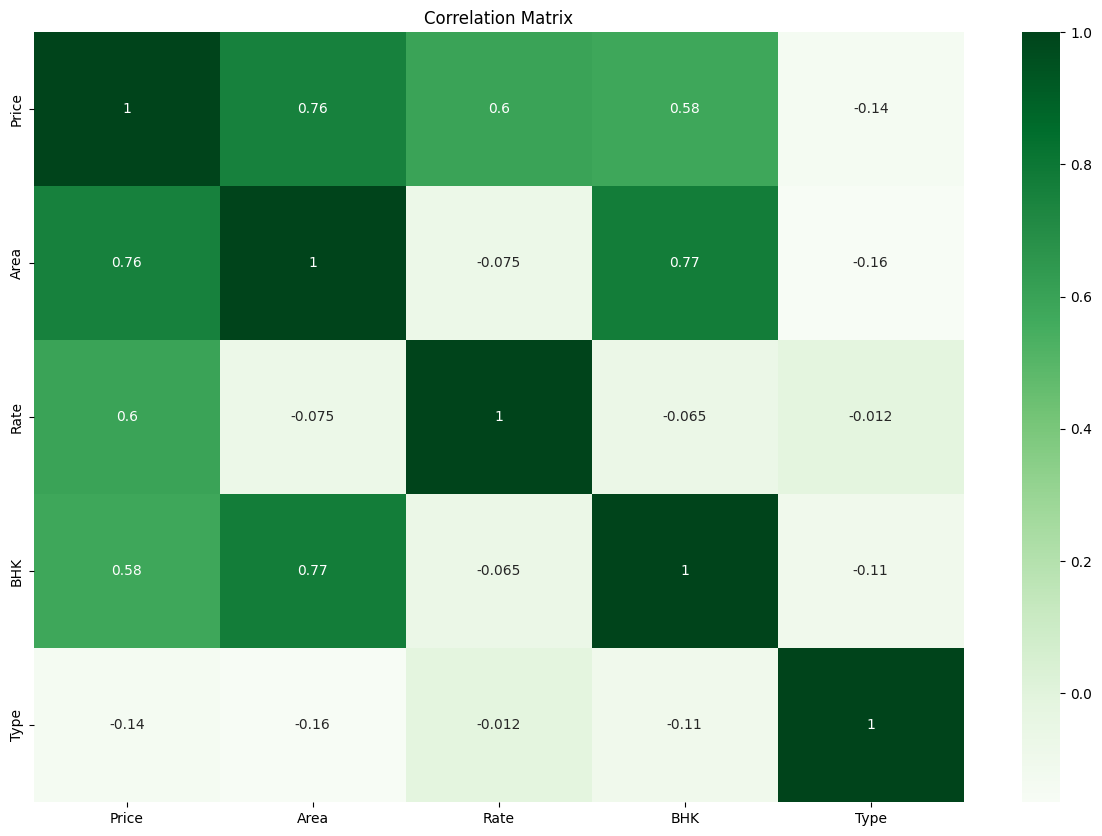

In [40]:
correlation = df9.drop('Location', axis='columns').corr()
sns.heatmap(correlation, annot=True, cmap='Greens')
plt.title("Correlation Matrix")

One Hot Encoding 

In [41]:
dummies1 = pd.get_dummies(df9.Location).astype(int)
dummies1.head()

,"Abbigere,Bangalore","Akshayanagar,Bangalore","Akurdi,Pune","Alandi,Pune","Ambattur Industrial Estate,Chennai","Ambattur,Chennai","Ambegaon Budruk,Pune","Ambegaon Pathar,Pune","Ambegaon,Pune","Aminpur,Hyderabad",...,"West Tambaram,Chennai","Whitefield,Bangalore","Wilson Garden,Bangalore","Worli,Mumbai","Yelahanka New Town,Bangalore","Yelahanka,Bangalore","Yemalur,Bangalore","Yerawada,Pune","Yeshwanthpur,Bangalore","Yewalewadi,Pune"
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
df10 = pd.concat([df9,dummies1], axis = 'columns')
df10.head()

,Price,Location,Area,Rate,BHK,Type,"Abbigere,Bangalore","Akshayanagar,Bangalore","Akurdi,Pune","Alandi,Pune",...,"West Tambaram,Chennai","Whitefield,Bangalore","Wilson Garden,Bangalore","Worli,Mumbai","Yelahanka New Town,Bangalore","Yelahanka,Bangalore","Yemalur,Bangalore","Yerawada,Pune","Yeshwanthpur,Bangalore","Yewalewadi,Pune"
0,4.787492,"Abbigere,Bangalore",8.006368,8.294050,4,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.105945,"Abbigere,Bangalore",8.242756,8.375630,4,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.941642,"Abbigere,Bangalore",7.901007,8.552560,4,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.905275,"Abbigere,Bangalore",8.188689,8.229511,6,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.828314,"Abbigere,Bangalore",8.006368,8.335671,6,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
df11 = df10.drop(['Location','Rate'], axis = 'columns')
df11.head()

,Price,Area,BHK,Type,"Abbigere,Bangalore","Akshayanagar,Bangalore","Akurdi,Pune","Alandi,Pune","Ambattur Industrial Estate,Chennai","Ambattur,Chennai",...,"West Tambaram,Chennai","Whitefield,Bangalore","Wilson Garden,Bangalore","Worli,Mumbai","Yelahanka New Town,Bangalore","Yelahanka,Bangalore","Yemalur,Bangalore","Yerawada,Pune","Yeshwanthpur,Bangalore","Yewalewadi,Pune"
0,4.787492,8.006368,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5.105945,8.242756,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.941642,7.901007,4,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.905275,8.188689,6,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.828314,8.006368,6,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Input Features

In [44]:
X = df11.drop('Price', axis = 'columns')
X.head()

,Area,BHK,Type,"Abbigere,Bangalore","Akshayanagar,Bangalore","Akurdi,Pune","Alandi,Pune","Ambattur Industrial Estate,Chennai","Ambattur,Chennai","Ambegaon Budruk,Pune",...,"West Tambaram,Chennai","Whitefield,Bangalore","Wilson Garden,Bangalore","Worli,Mumbai","Yelahanka New Town,Bangalore","Yelahanka,Bangalore","Yemalur,Bangalore","Yerawada,Pune","Yeshwanthpur,Bangalore","Yewalewadi,Pune"
0,8.006368,4,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8.242756,4,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7.901007,4,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8.188689,6,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.006368,6,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Target Feature

In [45]:
y = df11.Price
y.head()

0    4.787492
1    5.105945
2    4.941642
3    4.905275
4    4.828314
Name: Price, dtype: float64

Splitting data for Training and Testing

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

Support Vector Regression

In [47]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

0.7931241351269832

Ridge Regression

In [48]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge.score(X_test, y_test)

0.8941846049747036

Linear Regression

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.893109959277522

Decision Tree Regressor

In [50]:
dt = DecisionTreeRegressor(max_depth = 5, random_state = 1)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.6003880595275333

Random Forest Regressor

In [51]:
rf= RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.7908722153409694

XGB Regressor

In [52]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=1)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.7663547738816459

Stacking Model : (Ridge Regression, Linear Regression, Random Forest Regressor) ->  XGB Regressor

In [53]:
base_learners = [('ridge',Ridge()), ('lr', LinearRegression() ),('rf', RandomForestRegressor(n_estimators=100, random_state=1))]
meta_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=1)
stacking_model = StackingRegressor(estimators = base_learners, final_estimator = meta_model)
stacking_model.fit(X_train, y_train)
stacking_model.score(X_test, y_test)

0.8937196219061344

Model Evaluation

In [54]:
y_test_pred = stacking_model.predict(X_test)

In [55]:
def evaluation(y_test, y_test_pred):
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)
    print('MAE on test data =', round(mae_test, 4))
    print('RMSE on test data =', round(rmse_test, 4))
    print('R^2 on test data =', round(r2_test, 4))


In [59]:
def plot_result(y_test, y_test_pred):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.title('Stacking Model')
    plt.show()

MAE on test data = 0.1802
RMSE on test data = 0.2449
R^2 on test data = 0.8937


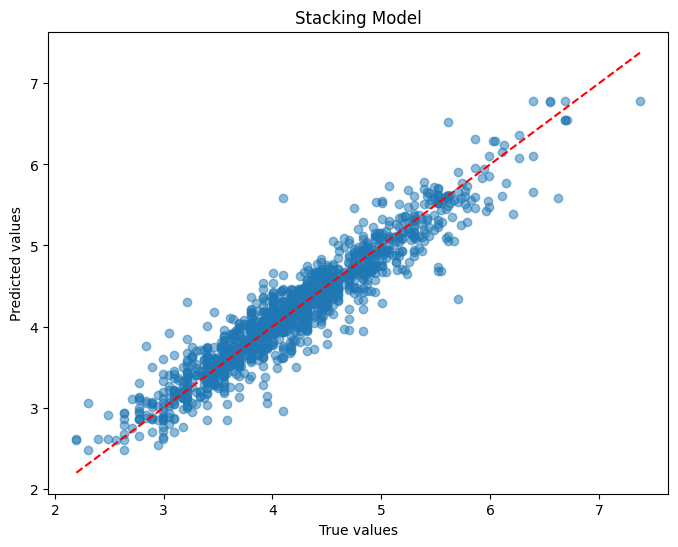

In [60]:
evaluation(y_test, y_test_pred)
plot_result(y_test, y_test_pred)

MAE on test data = 17.854
RMSE on test data = 41.5298
R^2 on test data = 0.8268


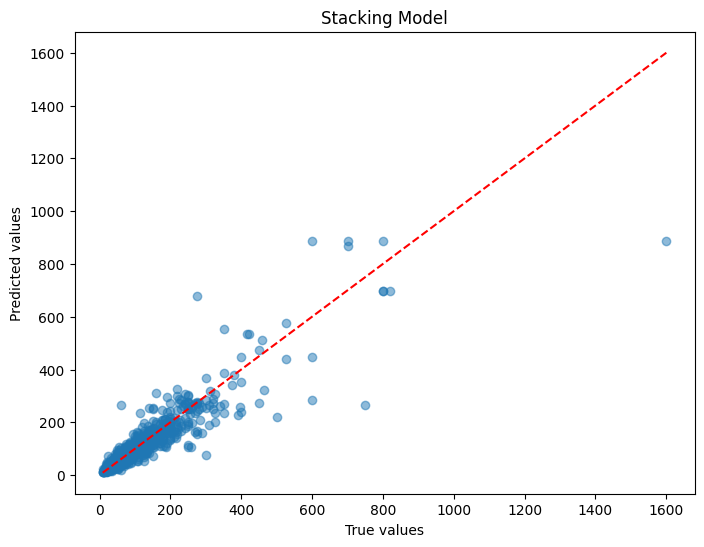

In [61]:
evaluation(np.exp(y_test), np.exp(y_test_pred))
plot_result(np.exp(y_test), np.exp(y_test_pred))

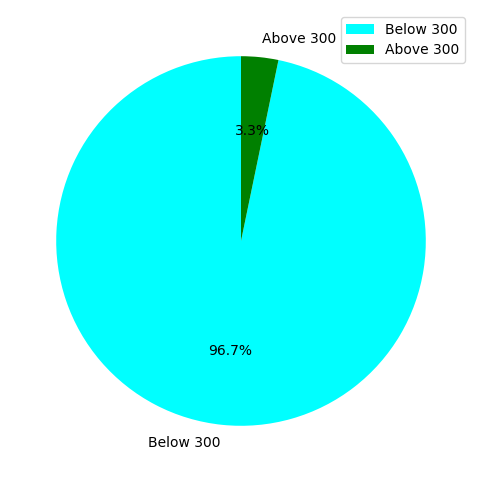

In [62]:
below_300 = y_train[np.exp(y_train) <= 300].shape[0]
above_300 = y_train[np.exp(y_train) > 300].shape[0]
value = [below_300, above_300]
label = ["Below 300", "Above 300"]
color = ['cyan', 'green']
plt.figure(figsize=(6,6))
plt.pie(value, labels = label, colors = color, startangle = 90, autopct = "%1.1f%%")
plt.legend()
plt.show()

Writing Model to pickle file

In [63]:
import pickle
with open('model.pickle','wb') as f:
    pickle.dump(stacking_model,f)

Location Names stored in a json file

In [64]:
import json
columns = {'data columns' : [col for col in X.columns]}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))